In [127]:
%matplotlib ipympl
import math
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "2"
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import pathlib

from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
import constants
import datasetloader
import model

In [128]:
tf.random.set_seed(constants.RANDOM_SEED)
DATASET_SAVED_PATH:pathlib.Path = pathlib.Path('./', 'ModelNet10')
""" Load the pointcloud dataset """
_, test_points, _, test_labels, class_map = datasetloader.processDataset(DATASET_SAVED_PATH, constants.UNIFORM_SAMPLE_COUNT)
# test_labels.shape = (test_labels.shape[0], 1)
print('TEST SHAPES ::: ', test_points.shape, test_labels.shape)

print('LOAD WEIGHTS FROM A CHECKPOINT')
checkpoint_path = pathlib.Path('./trained_model/checkpoints')

""" Create the tensor slices of the loaded dataset (for both training and testing) """
print('CREATEING THE TENSOR SLICES FOR THE TRAINING AND TESTING DATASET')
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_labels))
print('TEST DATASET SHAPES :::: ', test_dataset)

""" Apply shuffling only for the testing dataset """
test_dataset = test_dataset.shuffle(len(test_points)).batch(908)

TEST SHAPES :::  (908, 2048, 3) (908,)
LOAD WEIGHTS FROM A CHECKPOINT
CREATEING THE TENSOR SLICES FOR THE TRAINING AND TESTING DATASET
TEST DATASET SHAPES ::::  <TensorSliceDataset element_spec=(TensorSpec(shape=(2048, 3), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [129]:
""" Create the pointnet model """
print('INITIALIZE THE POINTNET MODEL')
model = model.createPointNetModel(constants.UNIFORM_SAMPLE_COUNT, constants.NUM_CLASSES)
latest = tf.train.latest_checkpoint(checkpoint_path)
# Load the previously saved weights
model.load_weights(latest)

INITIALIZE THE POINTNET MODEL


In [137]:
correct_predictions = 0
evaluate_count = 30
columns = 4
rows = int(math.ceil(evaluate_count / columns))
data = test_dataset.take(1)
points, labels = list(data)[0]

# print('DATA ::: ', list(data))
print('TOTAL DATA TO TAKE ::: ', total_data_to_take)
print('DATA SIZE ::: ', [(p.shape, l.shape) for p, l in list(data)])
print('LABELS ::: ', test_labels.shape)
print('POINTS ::: ', points.shape)
print('LABELS :::', labels.shape)
points = points[:evaluate_count, ...]
labels = labels[:evaluate_count, ...]

# raise IndentationError

# run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

TOTAL DATA TO TAKE :::  1
DATA SIZE :::  [(TensorShape([908, 2048, 3]), TensorShape([908]))]
LABELS :::  (908,)
POINTS :::  (908, 2048, 3)
LABELS ::: (908,)
1/1 [==============================] - 0s 175ms/step


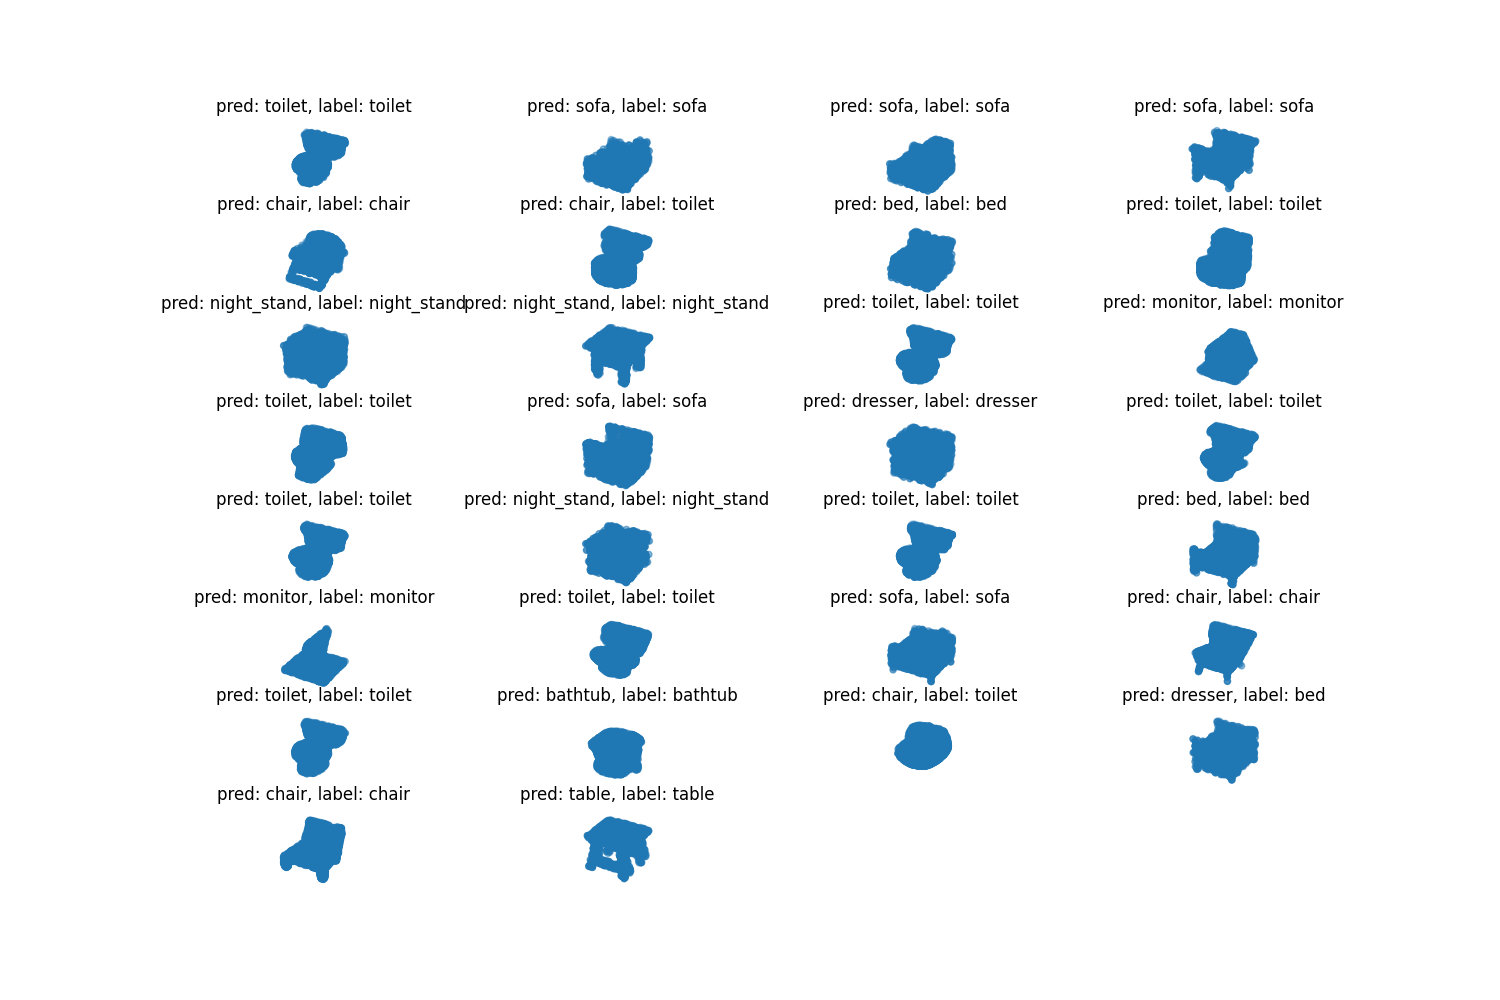

Prediction Accuracy : 90.0%, Total: 30, Correct: 27
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 480889), started 2:27:09 ago. (Use '!kill 480889' to kill it.)

In [138]:
def plot3D(fig, title, points, rows, columns, index):
    ax = fig.add_subplot(rows, columns, sindex + i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(title)
    ax.set_axis_off()    

correct_predictions = 0
#%matplotlib widget
# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(evaluate_count):
    title = "pred: {:}, label: {:}".format(class_map[preds[i].numpy()], class_map[labels.numpy()[i]])
    plot3D(fig, title, points, rows, columns, i + 1)
    if(preds[i].numpy() == labels.numpy()[i]):
        correct_predictions += 1
plt.show()
ratio = float(correct_predictions) / float(evaluate_count)
print(f'Prediction Accuracy : {round(ratio*100.0, 2)}%, Total: {evaluate_count}, Correct: {correct_predictions}')

%load_ext tensorboard
%tensorboard --host 10.180.89.159 --logdir logs